In [2]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

Using device: cuda
Classes: ['Flea_Allergy', 'Health', 'Ringworm', 'Scabies']
Epoch 1/15
Train Loss: 1.0564 Acc: 0.6575
Val Loss: 0.6011 Acc: 0.8200
✅ Saved Best Model
Epoch 2/15
Train Loss: 0.3753 Acc: 0.9337
Val Loss: 0.2788 Acc: 0.9100
✅ Saved Best Model
Epoch 3/15
Train Loss: 0.1211 Acc: 0.9750
Val Loss: 0.2296 Acc: 0.9400
✅ Saved Best Model
Epoch 4/15
Train Loss: 0.0361 Acc: 0.9962
Val Loss: 0.2128 Acc: 0.9300
Epoch 5/15
Train Loss: 0.0188 Acc: 1.0000
Val Loss: 0.2083 Acc: 0.9300
Epoch 6/15
Train Loss: 0.0108 Acc: 1.0000
Val Loss: 0.2052 Acc: 0.9400
Epoch 7/15
Train Loss: 0.0135 Acc: 0.9988
Val Loss: 0.2094 Acc: 0.9300
Epoch 8/15
Train Loss: 0.0066 Acc: 1.0000
Val Loss: 0.2087 Acc: 0.9400
Epoch 9/15
Train Loss: 0.0086 Acc: 0.9975
Val Loss: 0.1899 Acc: 0.9250
Epoch 10/15
Train Loss: 0.0057 Acc: 1.0000
Val Loss: 0.1760 Acc: 0.9450
✅ Saved Best Model
Epoch 11/15
Train Loss: 0.0030 Acc: 1.0000
Val Loss: 0.1844 Acc: 0.9350
Epoch 12/15
Train Loss: 0.0018 Acc: 1.0000
Val Loss: 0.1788 Acc

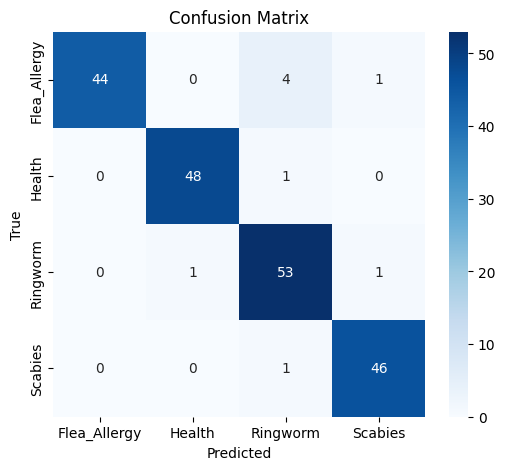

🔍 Grad-CAM Visualization...


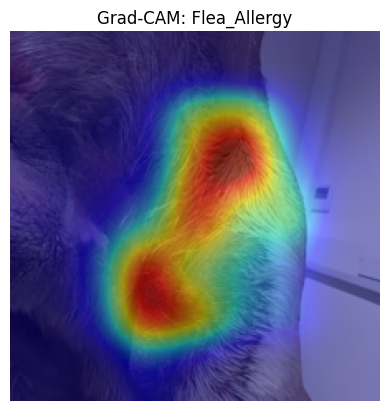

🧠 Predicted Class: Flea_Allergy


In [2]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import torchvision.transforms.functional as F

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
data_dir = "/kaggle/input/cat-disease/CAT SKIN DISEASE"

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

full_dataset = datasets.ImageFolder(data_dir, transform=transform['train'])
class_names = full_dataset.classes
print(f"Classes: {class_names}")

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = transform['val']

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 15
best_acc = 0.0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc.item())

    # Validation
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved Best Model")

# Evaluation
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Grad-CAM Visualization
print("🔍 Grad-CAM Visualization...")

# Reload model with gradients for CAM
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.to(device)
model.eval()

# GradCAM
cam_extractor = GradCAM(model, target_layer="layer4")

# Load image
img_path = "/kaggle/input/catimage/1000010771_x16.jpg"
img = Image.open(img_path).convert("RGB")
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
img_tensor = test_transform(img).unsqueeze(0).to(device)
img_tensor.requires_grad_()

# Inference
output = model(img_tensor)
pred_class = output.argmax(dim=1).item()
activation_map = cam_extractor(pred_class, output)

# Unnormalize and display
input_tensor = img_tensor.squeeze().cpu()
input_image = F.to_pil_image(input_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                              torch.tensor([0.485, 0.456, 0.406]).view(3,1,1))

result = overlay_mask(input_image, F.to_pil_image(activation_map[0], mode='F'), alpha=0.5)
plt.imshow(result)
plt.title(f"Grad-CAM: {class_names[pred_class]}")
plt.axis('off')
plt.show()

print(f"🧠 Predicted Class: {class_names[pred_class]}")


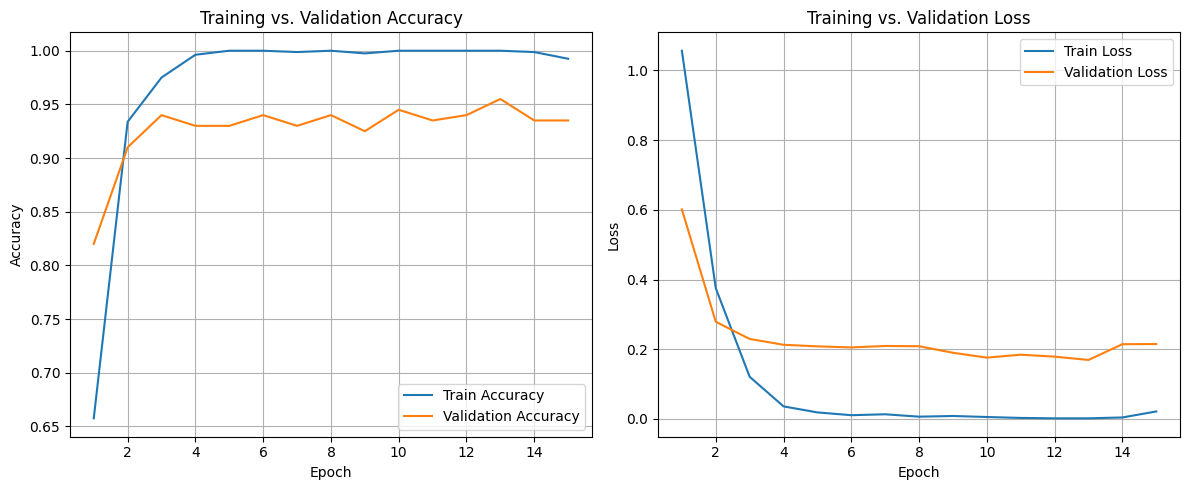

In [3]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
